## Loading data and preliminary analysis

In [1]:
# Install dependencies 

%pip install -r '../requirements.txt'

import nltk 

# nltk.download('punkt') 
# nltk.download('averaged_perceptron_tagger') 

# Set paths 

path_to_csv = '../Dataset/mentalhealthdetection.csv'

Defaulting to user installation because normal site-packages is not writeable
  Using cached cachetools-5.3.2-py3-none-any.whl.metadata (5.2 kB)
  Using cached certifi-2023.11.17-py3-none-any.whl.metadata (2.2 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached contourpy-1.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached fonttools-4.47.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (157 kB)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached google_auth-2.27.0-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached grpcio-1.60.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
  Using cached h5py-3.10.0-cp310-cp310-manyli

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import re
import random
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)

2025-05-16 20:17:21.332228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 20:17:21.332413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 20:17:22.941319: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 20:17:30.215086: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-16 20:18:11.511452: W tensorflow/compiler/tf2

In [3]:
data=pd.read_csv(path_to_csv, nrows=20)

In [4]:
data.head()

,Question_ID,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,2110618,Who does mental illness affect?,"Mental illness does can affect anyone, regardl..."
2,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
3,7657263,Can people with mental illness recover?,"When healing from mental illness, early identi..."
4,1619387,What should I do if I know someone who appears...,We encourage those with symptoms to talk to th...


In [5]:
# data preprocessing 

for i in range(data.shape[0]):
  data['Answers'][i]=re.sub(r'\n', ' ',data['Answers'][i])
  data['Answers'][i]=re.sub('\(', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r'\)', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r',', '',data['Answers'][i]) 
  data['Answers'][i]=re.sub(r'-', '',data['Answers'][i])
  data['Answers'][i]=re.sub(r'/', '',data['Answers'][i])  
  data['Answers'][i]=re.sub(r'/', '',data['Answers'][i])

/tmp/ipykernel_71493/3647870449.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Answers'][i]=re.sub(r'\n', ' ',data['Answers'][i])
/tmp/ipykernel_71493/3647870449.py:5: FutureWarning: ChainedAssignmentError: behaviour will change i

In [6]:
pairs=[]

for i in range(data.shape[0]):
  pairs.append(((data['Questions'][i]),data['Answers'][i]))

In [7]:
pairs                                     # questions

[('What does it mean to have a mental illness?',
  "Mental illnesses are health conditions that disrupt a person's thoughts emotions relationships and daily functioning."),
 ('Who does mental illness affect?',
  'Mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background.'),
 ('What are some of the warning signs of mental illness?',
  'Symptoms of mental health disorders vary depending on the type and severity of the condition.'),
 ('Can people with mental illness recover?',
  'When healing from mental illness early identification and treatment are of vital importance. '),
 ('What should I do if I know someone who appears to have the symptoms of a mental disorder?',
  'We encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional.'),
 ('How can I find a mental health professional for myself or my child?',
  'Feeling comfortable with the profes

## Data preprocessing 

In [8]:
input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()

for line in pairs:

  input_doc, target_doc = line[0], line[1]

  # Appending each input sentence to input_docs
  input_docs.append(input_doc)

  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))

  # Redefine target_doc below and append it to target_docs
  target_doc = '<START> ' + target_doc + ' <END>'

  target_docs.append(target_doc)

  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split():
    if token not in target_tokens:
      target_tokens.add(token)

input_tokens = sorted(list(input_tokens))  # contains all words of input_docs
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

In [9]:
input_docs

['What does it mean to have a mental illness?',
 'Who does mental illness affect?',
 'What are some of the warning signs of mental illness?',
 'Can people with mental illness recover?',
 'What should I do if I know someone who appears to have the symptoms of a mental disorder?',
 'How can I find a mental health professional for myself or my child?',
 'What treatment options are available?',
 'If I become involved in treatment, what do I need to know?',
 'What is the difference between mental health professionals?',
 'How can I find a mental health professional right for my child or myself?',
 'If I become involved in treatment what do I need to know?',
 'Where else can I get help?',
 'What should I know before starting a new medication?',
 'If I feel better after taking medication, does this mean I am "cured" and can stop taking it?',
 'How can I get help paying for my medication?',
 'Where can I go to find therapy',
 'Where can I learn about types of mental health treatment?',
 'What 

In [10]:
target_docs

["<START> Mental illnesses are health conditions that disrupt a person's thoughts emotions relationships and daily functioning . <END>",
 '<START> Mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background . <END>',
 '<START> Symptoms of mental health disorders vary depending on the type and severity of the condition . <END>',
 '<START> When healing from mental illness early identification and treatment are of vital importance . <END>',
 '<START> We encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional . <END>',
 '<START> Feeling comfortable with the professional you or your child is working with is critical to the success of the treatment . <END>',
 '<START> Different treatment options are available for individuals with mental illness . <END>',
 '<START> It is important to be as involved and engaged in the treatment process as possible .

In [11]:
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

In [12]:
input_features_dict

{'"': 0,
 ',': 1,
 '?': 2,
 'Can': 3,
 'How': 4,
 'I': 5,
 'If': 6,
 'What': 7,
 'Where': 8,
 'Who': 9,
 'a': 10,
 'about': 11,
 'affect': 12,
 'after': 13,
 'am': 14,
 'and': 15,
 'appears': 16,
 'are': 17,
 'available': 18,
 'become': 19,
 'before': 20,
 'better': 21,
 'between': 22,
 'can': 23,
 'care': 24,
 'child': 25,
 'cured': 26,
 'difference': 27,
 'different': 28,
 'disorder': 29,
 'do': 30,
 'does': 31,
 'else': 32,
 'feel': 33,
 'find': 34,
 'for': 35,
 'get': 36,
 'go': 37,
 'group': 38,
 'have': 39,
 'health': 40,
 'help': 41,
 'if': 42,
 'illness': 43,
 'in': 44,
 'inpatient': 45,
 'involved': 46,
 'is': 47,
 'it': 48,
 'know': 49,
 'learn': 50,
 'mean': 51,
 'medication': 52,
 'mental': 53,
 'my': 54,
 'myself': 55,
 'need': 56,
 'new': 57,
 'of': 58,
 'options': 59,
 'or': 60,
 'paying': 61,
 'people': 62,
 'professional': 63,
 'professionals': 64,
 'recover': 65,
 'right': 66,
 'should': 67,
 'signs': 68,
 'some': 69,
 'someone': 70,
 'starting': 71,
 'stop': 72,
 'su

## Encoder - Decoder model

In [13]:
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

In [14]:
encoder_input_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [15]:
decoder_target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

## Training

In [16]:
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model  
dimensionality = 256 # Dimensionality 
batch_size = 10   # The batch size and number of epochs
epochs = 500 

#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

2025-05-16 20:19:27.055683: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-16 20:20:03.659456: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-16 20:20:03.659574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-16 20:20:03.784887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-16 20:20:03.784989: I external/local_xla/xla/stream_executor

In [17]:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs) # Compiling

In [18]:
training_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 86)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 172)]          0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                351232    ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                              

In [19]:
plot_model(training_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)   # plot model

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')#Training
history1=training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)
training_model.save('training_model.h5')

Epoch 1/500


2025-05-16 20:22:35.624567: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-05-16 20:22:56.703425: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc7fd6dcc20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-16 20:22:56.703502: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX250, Compute Capability 6.1
2025-05-16 20:22:58.371026: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747416182.247750   72483 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 57s 829ms/step - loss: 1.8229 - accuracy: 0.2303 - val_loss: 1.7848 - val_accuracy: 0.0139
Epoch 2/500
2/2 [==============================] - 0s 64ms/step - loss: 1.8195 - accuracy: 0.2338 - val_loss: 1.7831 - val_accuracy: 0.0278
Epoch 3/500
2/2 [==============================] - 0s 87ms/step - loss: 1.8164 - accuracy: 0.0463 - val_loss: 1.7812 - val_accuracy: 0.5602
Epoch 4/500
2/2 [==============================] - 0s 67ms/step - loss: 1.8131 - accuracy: 0.5868 - val_loss: 1.7787 - val_accuracy: 0.4167
Epoch 5/500
2/2 [==============================] - 0s 77ms/step - loss: 1.8079 - accuracy: 0.5023 - val_loss: 1.7701 - val_accuracy: 0.0278
Epoch 6/500
2/2 [==============================] - 0s 96ms/step - loss: 1.7806 - accuracy: 0.2245 - val_loss: 1.7087 - val_accuracy: 0.6759
Epoch 7/500
2/2 [==============================] - 0s 84ms/step - loss: 1.7196 - accuracy: 0.6678 - val_loss: 1.6998 - val_accuracy: 0.6759
Epoch 8/500
2/2 [=============

/home/ahmed244/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


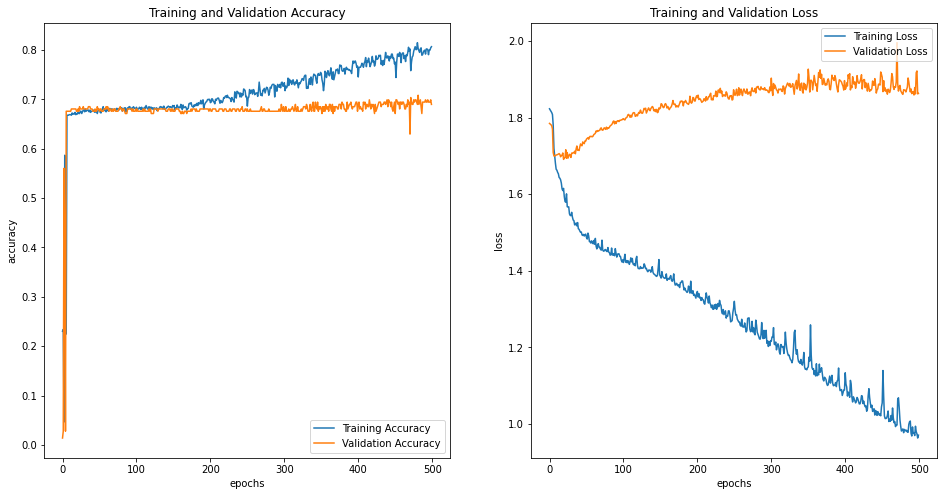

In [21]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Predictions

In [22]:
from keras.models import load_model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

In [23]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

In [24]:
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

In [25]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [26]:
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
          
          #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token
          
          #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
          
          #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.
          
          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence

In [27]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  
  #Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs. AMA!\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)
  
  #Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
    
  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
  
  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
chatbot = ChatBot()

## Demo

In [ ]:
chatbot.start_chat()

1/1 [==============================] - 0s 47ms/step
